<h2> Pykrev User Guide </h2> 

**Hello:** Welcome to the Pykrev user guide. In this document we will explore how to set up and use PyKrev in the analysis of mass spectrometry data. <br> <br>
**What is Pykrev?** Pykrev is a python package containing functions that make it easier to process mass spectrometry data in python. PyKrev is intended to be used in the final part of mass spectrometry data analysis, after the spectra have been calibrated and peaks have been assigned to molecular formula. <br> <br>
**What data do I need to use PyKrev?** PyKrev was designed to analyse low weight molecular formula uncovered from high resolution mass spectra. The core data sets needed to use PyKrev are lists of molecular formula strings and corresponding numpy arrays of peak intensities and mz values. PyKrev can parse an output .csv file from the formularity software to generate these datasets for you. <br> <br>
**PyKrev dependencies:** PyKrev is written in Python 3. To use PyKrev you must have the matplotlib, numpy and pandas packages installed. For additional functionality such as gaussian density estimation and multivariate analysis, you will also need to install SciPy. <br> <br>
**Installing PyKrev:** To install pykrev you need to download the entire repository from GitHub. Once downloaded, you can either run your analysis from inside the root directory of the PyKrev repository, or [add PyKrev to your python path](https://bic-berkeley.github.io/psych-214-fall-2016/using_pythonpath.html).


**Overview of PyKrev Module Organisation:**
![PyKrev Module Organisation](pykrev_module_organisation.png "Title")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pykrev as pk

<h3> Basic formula manipulation </h3>

For almost all functionality PyKrev requires lists of molecular formula strings to work. For some functionality PyKrev also requires numpy arrays of corrsponding peak intensities and mz_values. Import these into Python however you like. If you want to analyse formula assigned using [formularity software](https://omics.pnl.gov/software/formularity), you can use pk.read_formularity: this function automatically filters out mass charge values that don't have C and H atoms assigned to them.

In [5]:
#read a formularity file, and extract formula, peak intensities, mass charge ratios, and compound classes. 
formularity_A = pk.read_formularity('example_data/formularity_example_A.csv',pi_col = 'peak_intensity',pi = True, mz=True,cclass = True) #pi_col provides the column name for peak intensities.
A_formula, A_peak_intensity, A_mass_charge, A_compound_class = formularity_A #unpack the tuple, note the order
#unpack the tuple directly into separate variables
B_formula,B_peak_intensity, B_mass_charge, B_compound_class = pk.read_formularity('example_data/formularity_example_B.csv',pi_col = 'peak_intensity',pi = True, mz=True,cclass = True)
C_formula,C_peak_intensity, C_mass_charge, C_compound_class = pk.read_formularity('example_data/formularity_example_C.csv',pi_col = 'peak_intensity',pi = True, mz=True,cclass = True)
#A_formula is a list
print(type(A_formula))
#A_peak_intensity is an nd.array
print(type(A_peak_intensity))

#a separate way of loading formula
brite_df = pd.read_excel('example_data/Brite_DF.xlsx',index_col = 0) #Load the BRITE Biological molecules excel file
brite_formula = brite_df['F'].to_list() #extract the formula
brite_intensities = np.random.rand(len(brite_formula)) #generate a random array of peak intensities

<class 'list'>
<class 'numpy.ndarray'>


Almost all functions in PyKrev take a list of molecular formula strings as input. Below we calculate C H N O P S counts in each formula and element ratios using *element_counts* and *element_ratios*.

In [6]:
A_counts = pk.element_counts(A_formula) #the result is a list of len(A_formula) in which each item is a dictionary containing C,H,N,O,P,S counts
A_ratios = pk.element_ratios(A_formula,ratios = ['HC','OC','NC']) #the result is a list of len(A_formula) in which each item is a dictionary containing the ratios given in ratios 
print(A_formula[16])
print(A_counts[16])
print(A_ratios[16])

C8H8O4
{'C': 8, 'H': 8, 'N': 0, 'O': 4, 'P': 0, 'S': 0}
{'HC': 1.0, 'OC': 0.5, 'NC': 0.0}


It is also possible to calculate double bound equivalent, aromaticity index, and [nominal oxidation state of carbon](https://www.sciencedirect.com/science/article/abs/pii/S0016703711000378?via%3Dihub).

In [7]:
A_dbe = pk.double_bond_equivalent(A_formula) # a warning message appears if there are any counts that give negative values, these are set to zero
A_ai = pk.aromaticity_index(A_formula,index_type = 'rAI') #index_type can be reformulated or original, and account for a modified O coefficient.
A_nosc = pk.nominal_oxidation_state(A_formula) #the output is a numpy array of len(counts)

pykrev can be used to calculate average, exact monoisotopic and nominal monoisotopic masses from a list of formula strings. You can also calculate the kendrick mass and kendrick mass defect. 

In [8]:
A_atomic_mass = pk.calculate_mass(A_formula, method = 'average') ## exact weighted average mass
A_nominal_mass = pk.calculate_mass(A_formula, method = 'nominal') ## i.e. rounded monoisotopic masses
A_exact_mass = pk.calculate_mass(A_formula, method = 'monoisotopic') ## exact monoisotopic masses
A_kendrick_mass, A_kendrick_mass_defect = pk.kendrick_mass_defect(A_formula,A_mass_charge, base = ['CH2']) # Kendrick mass and kendrick mass defect

Finally, PyKrev can be used to perform set analysis on several lists of molecular formula. It can give you the unique formula in each list using *unique_formula* , the missing formula in each list using *missing_formula* , or all the intersections between them using *find_intersections*.



In [9]:
unique_formula  = pk.unique_formula(A_formula,B_formula,C_formula, group_labels = ['A','B','C']) #the result is a dictionary in which each key is a group_label and each value is a list containing the unique formula 
missing_formula = pk.missing_formula(A_formula,B_formula,C_formula, group_labels = ['A','B','C']) #
intersections =  pk.find_intersections(formula_lists = [A_formula,B_formula,C_formula],group_labels = ['A','B','C']) #output is a dictionary in which keys are tuples and values are sets containing formula 

intersections[('A','B','C')] #formula found in all lists 

print('# Unique formula A: ',len(unique_formula['A'])) #number of unique formula in A
print('# Unique formula A from intersections: ',len(intersections[('A',)])) #number of unique formula in A from intersections

print('# Missing formula A: ', len(missing_formula['A'])) #number of missing formula in A
print('# Missing formula A from intersections: ',len(intersections[('B','C')])) #number of missing formula in A from intersections 

#Note unique_formula['A'] is a list whereas intersections[('A',)] is a set

# Unique formula A:  804
# Unique formula A from intersections:  804
# Missing formula A:  28
# Missing formula A from intersections:  28


Remember, if you are ever confused you can call help on a function!

In [10]:
help(pk.find_intersections)

Help on function find_intersections in module pykrev.formula.find_intersections:

find_intersections(formula_lists, group_labels, exclusive=True)
    Docstring for function pyKrev.find_intersections
    
    This function compares n lists of molecular formula and outputs a dictionary containing the intersections between each list.
    
    Use
    ----
    find_intersections([list_1,..,list_n],['group_1',...,'group_n'])
    
    Returns a dictionary in which each key corresponds to a combination of group labels 
    and the corresponding value is a set containing the intersections between the groups in that combination.  
    
    Parameters
    ----------
    formula_lists: a list containing n lists of molecular formula. Each item in the sub list should be a formula string.
    group_labels: a list containing n strings of corresponding group labels.
    exclusive: True or False, depending on whether you want the intersections to contain only unique values.



<h3> Plotting </h3>

PyKrev can be used to make a range of van Krevelen style plots from your data. Plotting in PyKrev is performed using the [API interface of matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html), this means that you can continue to customise your plots once they have been produced using a range [matplotlib.pyplot commands](https://matplotlib.org/api/pyplot_summary.html). <br> <br>  A standard van krevelen plot is made using van_krevelen_plot on a list of molecular formula strings. The function can take keyword arguments for [pyplot.scatter.](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter)

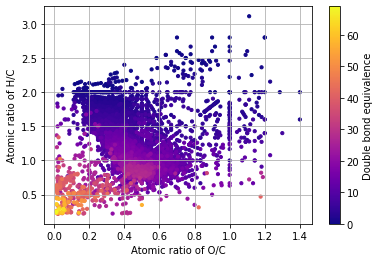

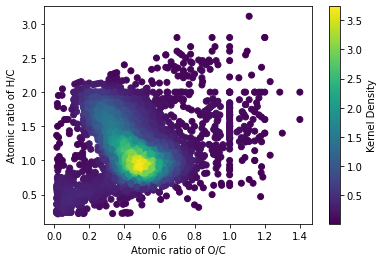

In [11]:
#Here we make a van Krevelen style plot where the y axis represents N/C values, and colour code the points by double bond equivalence 
plt.figure()
pk.van_krevelen_plot(A_formula, y_ratio = 'HC',c = A_dbe,s = 10,cmap = 'plasma') #van_krevele_plot takes any keyword arguments that can be passed to pyplot.scatter() 
cbar = plt.colorbar() #add a colour bar 
cbar.set_label('Double bond equivalence')
#PyKrev.van_krevelen_plot can take the value 'density' for the key word argument 'c' to colour code points based on kernel density
plt.figure()
pk.van_krevelen_plot(A_formula,c='density')
plt.colorbar().set_label('Kernel Density')
plt.grid(False)

We can also make 2d histograms based on a list of molecular formula using van_krevelen_histogram. The function can take keyword arguments passed to [pyplot.hist2d](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist2d.html). <br> <br>If the bin sizes are given as scalar values, a 'density index' is returned. This is a value between 0 and 1 made by dividing the average number of points by the number of points in the most populated bin, giving average relative density (for 100 bins a score of 1 means all bins are equally dispersed, and a score of 0.01 means all points fall into one bin).

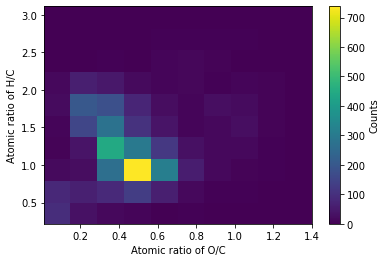

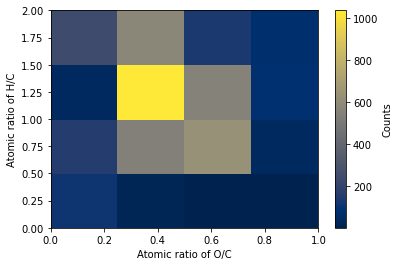

In [12]:
plt.figure()
d_index = pk.van_krevelen_histogram(A_formula,bins = [10,10],cmap = 'viridis') # van_krevelen_histogram takes any key word argument that can be passed to pyplot.hist2d
cbar = plt.colorbar()
cbar.set_label('Counts')

#a histogram can also be made with a range of values for bins
plt.figure()
d_index = pk.van_krevelen_histogram(A_formula,bins = [np.linspace(0,1,5),np.linspace(0,2,5)],cmap = 'cividis') # van_krevelen_histogram takes any key word argument that can be passed to pyplot.hist2d
cbar = plt.colorbar()
cbar.set_label('Counts')


The multi_van_krevelen_plot function plots several different lists of molecular formula onto the same van krevelen plot, using a different marker and colour for each. Below I plot each of the different compound classes in the [BRITE compounds with biological roles dataset](https://www.genome.jp/kegg-bin/get_htext?br08001.keg) with a different marker.   

In [13]:
#Specific analysis of compound classes in the brite dataset 
Organic_Acids = brite_df[brite_df['A'] == 'Organic acids']['F'].dropna()
Lipids = brite_df[brite_df['A'] == 'Lipids']['F'].dropna()
Carbohydrates = brite_df[brite_df['A'] == 'Carbohydrates']['F'].dropna()
Nucleic_acids = brite_df[brite_df['A'] == 'Nucleic acids']['F'].dropna()
Peptides = brite_df[brite_df['A'] == 'Peptides']['F'].dropna()
Vitamins_and_cofactors = brite_df[brite_df['A'] == 'Vitamins and Cofactors']['F'].dropna()
Steroids = brite_df[brite_df['A'] == 'Steroids']['F'].dropna()
Hormones_and_transmitters = brite_df[brite_df['A'] == 'Hormones and transmitters']['F'].dropna()
Antibiotics = brite_df[brite_df['A'] == 'Antibiotics']['F'].dropna()

Multi van krevelen plots require multiple molecular formula lists followed by key word arguments specifying the alpha value (transparency), colour, symbol type, edge colour and label that each of the ratio lists will be plotted with. Additionally the function accepts any keyword arguments for pyplot.scatter, with the exception of alpha, marker, c, edgecolors and label.

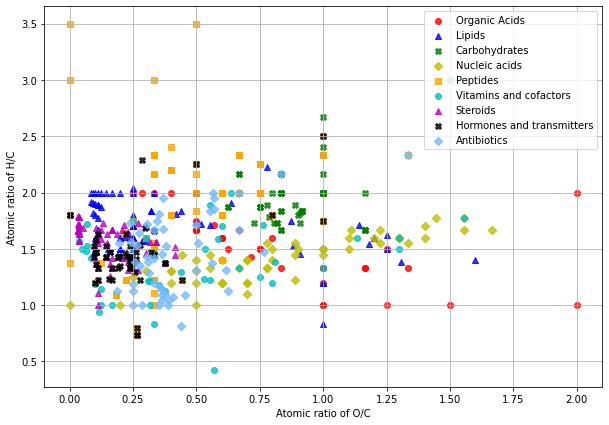

In [14]:
#multi_van_krevelen_plot of these compounds
plt.figure(figsize  = (10,7))
pk.multi_van_krevelen_plot(Organic_Acids,Lipids,Carbohydrates,Nucleic_acids,Peptides,Vitamins_and_cofactors,Steroids,Hormones_and_transmitters,Antibiotics,
                                            alphas = [0.8] * 9, #the transparency of the points
                                            colours = ['r','b','g','y','orange','c','m','k','xkcd:sky blue'], #point colours
                                            symbols = ['o','^','X','D','s','o','^','X','D'], #point symbols
                                            edge_colours = [None] * 9, #point edge colours
                                            group_labels= ['Organic Acids', 'Lipids', 'Carbohydrates','Nucleic acids','Peptides','Vitamins and cofactors','Steroids','Hormones and transmitters', 'Antibiotics'])

legend = plt.legend(loc='best')

A special type of multi van krevelen plot is the unique plot and the missing plot. For multiple lists of formula, these functions perform a multi van krevelen plot in which either the unique or the missing compounds in each list are plotted on top of one another. In addition to creating a plot, these functions also return the unique or missing groups produced by pk.unique_formula or pk.missing_formula.

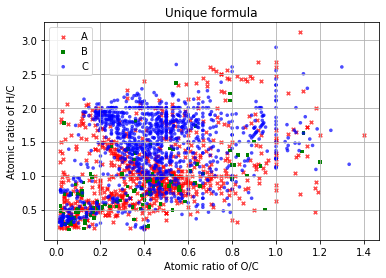

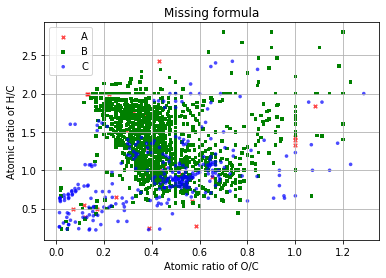

In [15]:
plt.figure(figsize = (6,4))
unique_formula = pk.unique_plot(A_formula,B_formula,C_formula,s = 13,group_labels = ['A','B','C'],alphas = [0.7,1,0.7],symbols = ['x','s','o'], y_ratio = 'HC')
plt.title('Unique formula')
plt.legend()

plt.figure(figsize = (6,4))
missing_formula = pk.missing_plot(A_formula,B_formula,C_formula,s = 13,group_labels = ['A','B','C'],alphas = [0.7,1,0.7],symbols = ['x','s','o'])
plt.title('Missing formula')
plt.legend()

[**Kendrick mass defect plots**](https://doi.org/10.1021/acs.analchem.9b03333) are a useful way to identify chemically related compounds based on exact measurements. With pykrev you can make them using pk.kendrick_mass_defect_plot.

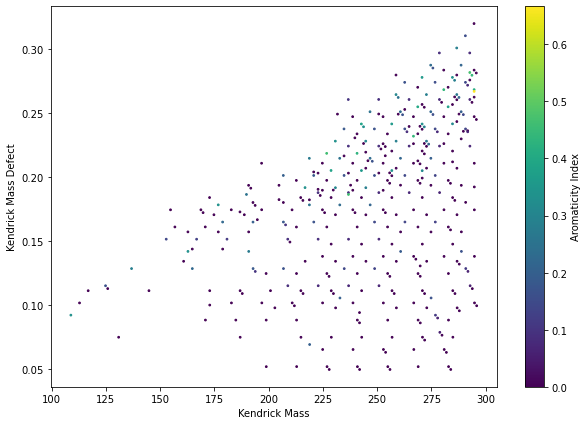

In [16]:
plt.figure(figsize = (10,7))
kendrickMass, kendrickMassDefect = pk.kendrick_mass_defect_plot(A_formula[:400],A_mass_charge[:400],base = ['CH2'], s = 3, c = A_ai[:400])
plt.colorbar().set_label('Aromaticity Index')

**Atomic Class Plots** enable you to see the distribution of an element within your sample, and the summary statistics show the mean, median and standard deviation of that distribution.  

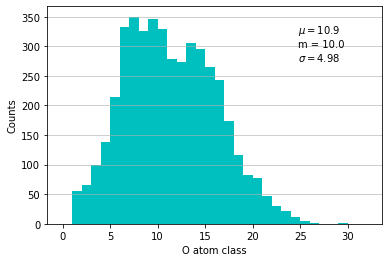

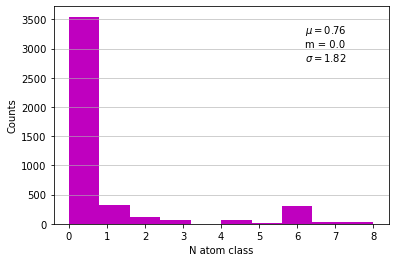

In [17]:
plt.figure()
(u,m,sig) = pk.atomic_class_plot(A_formula, element = 'O', color = 'c', summary_statistics = True, bins = range(0,33))
plt.xticks()
plt.figure()
(u,m,sig) = pk.atomic_class_plot(A_formula, element = 'N', color = 'm', summary_statistics = True)

**Compound class plots** are useful to see the breakdown of compound classes in a sample. There is more about the *compound_class* function in the next section.

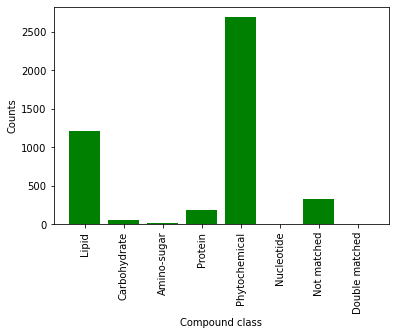

In [18]:
plt.figure()
pk.compound_class_plot(A_formula,A_mass_charge, color = 'g', method = 'MSCC')

**Mass histograms** show the distribution of mass in your sample. You can specify the bin width in mass units, and the method used to calculate mass. 

Text(0.5, 0, 'Mass value')

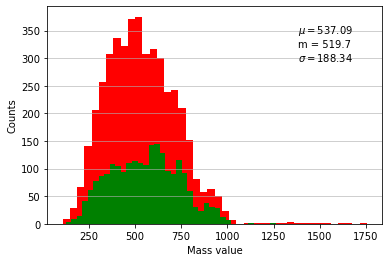

In [19]:
plt.figure()
pk.mass_histogram(A_formula, method = 'mz', mz_list = A_mass_charge, bin_width = 40, summary_statistics=True, color = 'red')
pk.mass_histogram(B_formula, method = 'monoisotopic', bin_width = 30, summary_statistics=False, color = 'green')
plt.xlabel('Mass value')

**Mass spectrum** recreates a mass spectrum based on an assiged formula list. You can specify the method used to calculate mass, and whether or not to normalise the peak intensity list.

(150.0, 1000.0)

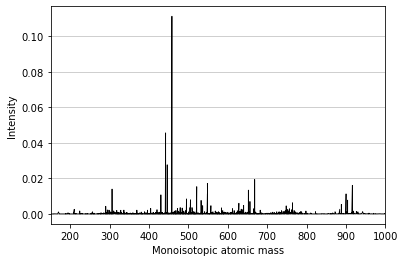

In [20]:
plt.figure()
pk.mass_spectrum(A_formula,A_peak_intensity, method = 'monoisotopic',normalise = True)
plt.xlim(150,1000)

**Finally, PyKrev can be used alongside UpSetPlot to make Upset plots, but that is covered in a [separate user guide](https://github.com/Kzra/pykrev/blob/master/docs/UpSet%20plots%20with%20PyKrev.md)**

Matplotlib offers a range of customisation options to change the appearance of plots. Be sure to play around with key word arguments to get the plots just how you like them. In addition it's possible to [change the appearance of the text](https://matplotlib.org/tutorials/introductory/customizing.html) and [the overall style of the plot.](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html) Personally, I like the ggplot style sheet... but maybe that's just me. 

<h3> Chemical diversity and multivariate analysis </h3>

PyKrev can be used to predict the compound class make up of a sample, it can also be used to compute diversity values (akin to biological diversity metrics) based on the peak intensities of molecular formula present in a sample. Finally, it can also be used to concatenate multiple formula and peak intensity lists into a sample data matrix which can then be used to perform statistical ordination such as PCA and PCoA. 

To estimate the compound class composition of a sample, use the *compound_class* function. A variety of criteria can be used to predict compound class, which are discussed in the function's docstring. We are going to use the [MSCC algorithm](https://pubs.acs.org/doi/full/10.1021/acs.analchem.8b00529).

In [21]:
compounds, counts = pk.compound_class(A_formula,mass_list = A_mass_charge, method = 'MSCC') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)

{'Lipid': 1217, 'Carbohydrate': 60, 'Amino-sugar': 12, 'Protein': 185, 'Phytochemical': 2690, 'Nucleotide': 0, 'Not matched': 328, 'Double matched': 0}


To compute diversity metrics we can use *diversity_indices*. *Diversity_indices* requires a list of molecular formula, and a corresponding list of peak intensities. Based on these datasets the function calculates molecular richness, abundance-based ([Shannon-wiener](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) and [Gini-simpson](https://en.wikipedia.org/wiki/Diversity_index#Gini%E2%80%93Simpson_index) and functional-based ([using rao's quadratic entropy](https://www.sciencedirect.com/science/article/pii/S0040580909001117)) diversity values for the sample. [Tanentzap et al. (2019)](https://www.pnas.org/content/116/49/24689) shows how these measurements can be applied in chemical analysis.

In [22]:
A_diversity = pk.diversity_indices(A_formula,A_peak_intensity,verbose = True, indices = ['SW','DBE']) #diversity values are saved into a dictionary 
A_diversity['D_a_SW'] #shannon wiener diversity
A_diversity['D_f_DBE']#functional diversity based on double bond equivalence 

Abundanced based diversity:
Shannon-Wiener Index: 6.277064176599099 

Functional based diversity:
Raos Quadratic Index (DBE):  3.7281690572583996


3.7281690572583996

In order to cross compare molecular formula datasets in multivariate analysis it is first required to construct a sample data matrix in which each column represents a molecular formula each row a different sample. The len(rows) is equal to len(samples) and the len(columns) is equal to the len(set(all_formula)), where all_formula is all formula found across the samples. \[row,col\] value is the peak intensity of a particular molecular formula in a particular sample. If the formula is not present in a sample the peak intensity is set as zero. We can construct this sample data matrix using pk.ordination_matrix.

In [23]:
sample_data_matrix = pk.ordination_matrix(molecular_formulas = [A_formula,B_formula,C_formula],
                                          peak_intensities = [A_peak_intensity,B_peak_intensity,C_peak_intensity],
                                          group_names = ['A','B','C'])
all_formula = A_formula + B_formula + C_formula
assert len(sample_data_matrix.iloc[0,:]) == len(set(all_formula))

sample_data_matrix.iloc[:,1:10]

,C27H46O14,C41H78N2O5,C45H38O22,C28H41N3O12,C40H52O12,C22H34O9,C21H38O7,C43H28N2O11,C32H44O10
A,2.20834e+06,1.85959e+06,6.51722e+07,0,7.72674e+06,1.20778e+06,4.41814e+06,0,3.41122e+06
B,0,0,5.9798e+07,2.39416e+06,9.46245e+06,0,3.41825e+06,0,2.33414e+06
C,7.39868e+06,0,6.38974e+06,0,3.38353e+06,6.46982e+06,2.53104e+07,3.90361e+06,3.57215e+06


We can convert the peak intensities in the sample data matrix to relative intensities (so that each column sums to 1) by using pk.relative_intensity

In [24]:
ri_matrix = pk.relative_intensity(sample_data_matrix)
sum(ri_matrix[:,0]) #columns sum to 1 

1.0

We could perform PCA (Principal component analysis) directly on the relative intensity matrix, or compute a non-euclidean distance measure, such as [bray-curtis dissimilarity](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) to perform PCoA (Principal coordinate analysis).  This can be done using pk.bray_curtis_matrix.

In [25]:
bray_curtis = pk.bray_curtis_matrix(ri_matrix) #note bray_curtis_matrix requires a numpy.array so won't work directly on sample_data_matrix

To finish let's perform PCoA to compare our samples. To do this we are going to need the stats module of the skbio package.

In [26]:
#from skbio import stats
#pcoa_results = stats.ordination.pcoa(bray_curtis,number_of_dimensions = 3)
#pcoa_results.perc_exp = np.round((pcoa_results.proportion_explained[0:3]*100),3)
#group_names = ['A','B','C']
#colours = ['r','g','b']
#plt.figure()
#for i in range(0,len(group_names)):
#    plt.scatter(pcoa_results.samples.iloc[i,0],pcoa_results.samples.iloc[i,1], c = colours[i],label = group_names[i])
#plt.xlabel((str(pcoa_results.perc_exp[0]) + '%' + ' PC1'))
#plt.ylabel((str(pcoa_results.perc_exp[1]) + '%' + ' PC2'))
#plt.legend()
#plt.title('PCoA Example')

That's the end of the user guide. Thanks for reading and good luck! The package is still early development and i'd greatly appreciate any feedback. If you'd like to contribute code or feature ideas, that'd be awesome too. You can can contact me at ezra.kitson@ed.ac.uk. Last update:  27/11/2020